In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.nn import MSELoss

from model_builder import RNN
from engine import train
from data_setup import create_dataloaders
from utils import split_data

c:\Users\nemet\DeepLearning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Prepare paths
data_path = '../data/'
processed_data_path = os.path.join(data_path, 'processed')

# Read personal data from excel
personal_data = pd.read_excel(os.path.join(data_path, 'PersonalData.xlsx'))

# Read the data that is the result of the converted videos
data = pd.read_csv(os.path.join(processed_data_path, 'AllSquats.csv'))

# Merge personal and video data
data = pd.merge(data, personal_data, on='Id')

In [20]:
import seaborn as sns

In [22]:
data.columns

Index(['FileId', 'Id', 'CameraPosition', 'SetNumber', 'Repetitions',
       'RepNumber', 'Load', 'Lifted', 'Timestamp', 'NoseX', 'NoseY', 'NoseZ',
       'LeftShoulderX', 'LeftShoulderY', 'LeftShoulderZ', 'RightShoulderX',
       'RightShoulderY', 'RightShoulderZ', 'LeftElbowX', 'LeftElbowY',
       'LeftElbowZ', 'RightElbowX', 'RightElbowY', 'RightElbowZ', 'LeftWristX',
       'LeftWristY', 'LeftWristZ', 'RightWristX', 'RightWristY', 'RightWristZ',
       'LeftIndexX', 'LeftIndexY', 'LeftIndexZ', 'RightIndexX', 'RightIndexY',
       'RightIndexZ', 'LeftHipX', 'LeftHipY', 'LeftHipZ', 'RightHipX',
       'RightHipY', 'RightHipZ', 'LeftKneeX', 'LeftKneeY', 'LeftKneeZ',
       'RightKneeX', 'RightKneeY', 'RightKneeZ', 'LeftAnkleX', 'LeftAnkleY',
       'LeftAnkleZ', 'RightAnkleX', 'RightAnkleY', 'RightAnkleZ',
       'LeftFootIndexX', 'LeftFootIndexY', 'LeftFootIndexZ', 'RightFootIndexX',
       'RightFootIndexY', 'RightFootIndexZ', 'ThoraxX', 'ThoraxY', 'ThoraxZ',
       'PelvisX', 'Pelv

<Axes: xlabel='Timestamp', ylabel='RightShoulderZ'>

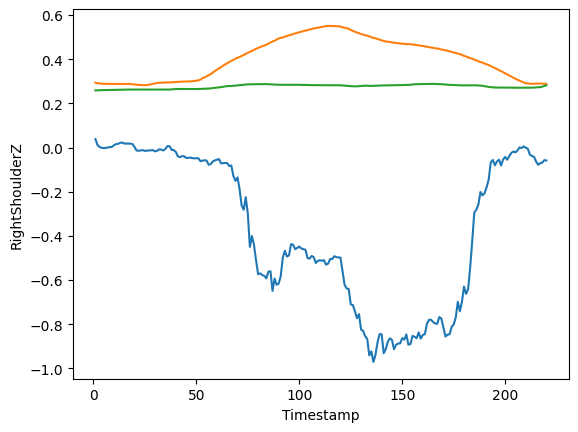

In [35]:
sns.lineplot(data=data.loc[data['FileId'] == '001_06_01_01_110_1_R'], x='Timestamp', y='RightShoulderZ')
sns.lineplot(data=data.loc[data['FileId'] == '001_06_01_01_110_1_R'], x='Timestamp', y='RightShoulderY')
sns.lineplot(data=data.loc[data['FileId'] == '001_06_01_01_110_1_R'], x='Timestamp', y='RightShoulderX')

In [3]:
# Calculate the maximum load that was passed
max_load = data.loc[data['Lifted'] == 1, ['Id', 'Load']].groupby(by='Id', as_index=False).max()
max_load = max_load.rename(columns={'Load': 'MaxLoad'})
data = pd.merge(data, max_load, on='Id')

# Calculate what percentage of the maximum load is the current load
data['PercentageMaxLoad'] = 100 * data['Load'] / data['MaxLoad']

del data['MaxLoad']


# Get only lifted approaches
data = data.loc[data['Lifted'] == 1]

# Variables that aren't needed in the first run
to_drop = [
    'Id', 'Age', 'Height', 'Weight', 'PastInjuries', 'LastInjury', 'PainDuringTraining', 'SquatRecord',
    'BenchPressRecord', 'DeadliftRecord', 'PhysicalActivities', 'SetNumber', 'Load', 'Lifted', 'Timestamp']

data = data.drop(columns=to_drop)

# Categorical variables that need to be one hot encoded
to_one_hot = [
    'ProficiencyLevel', 'EquipmentAvailability', 'TrainingProgram', 'TrainingFrequency', 'CameraPosition']

dataframe = pd.get_dummies(data, columns=to_one_hot, dtype=int)

# Move the PercentageMaxLoad column to the end of the dataframe
percentage = dataframe.pop('PercentageMaxLoad')
dataframe['PercentageMaxLoad'] = percentage

In [6]:
# dataframe.to_csv('ProcessedSquats.csv', index=False)

In [2]:
# # Setup directories
# data_dir = '../data/processed/'

# # Read prepared dataframe
# data = pd.read_csv(os.path.join(data_dir, 'ProcessedSquats.csv'))

In [4]:
data = dataframe.copy()

<Axes: xlabel='PercentageMaxLoad', ylabel='Count'>

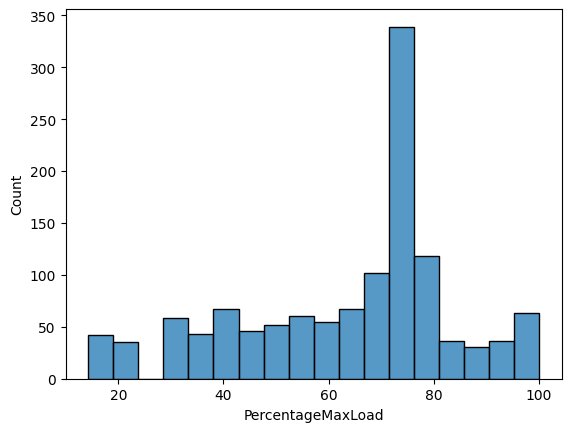

In [5]:
import seaborn as sns

sns.histplot(data=data.drop_duplicates(subset='FileId'), x='PercentageMaxLoad')

In [5]:
file_ids = split_data(data)

In [6]:
# Setup hyperparameters
BATCH_SIZE = 256
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=data,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [12]:
INPUT_SIZE = 78
HIDDEN_SIZE = 256
NUM_LAYERS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float64

NUM_EPOCHS = 100
LEARNING_RATE = 0.001

model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

model = model.to(device=DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = MSELoss()

In [13]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  1%|          | 1/100 [00:01<02:16,  1.38s/it]

Epoch: 1 | train loss: 4450.7399 | validation loss: 4242.3862


  2%|▏         | 2/100 [00:02<02:05,  1.28s/it]

Epoch: 2 | train loss: 4039.2908 | validation loss: 3702.0420


  3%|▎         | 3/100 [00:03<02:00,  1.25s/it]

Epoch: 3 | train loss: 3608.8108 | validation loss: 3412.3835


  4%|▍         | 4/100 [00:04<01:58,  1.23s/it]

Epoch: 4 | train loss: 3368.7711 | validation loss: 3250.1392


  5%|▌         | 5/100 [00:06<01:55,  1.22s/it]

Epoch: 5 | train loss: 3219.8605 | validation loss: 3128.7800


  6%|▌         | 6/100 [00:07<01:54,  1.21s/it]

Epoch: 6 | train loss: 3101.9615 | validation loss: 3015.8877


  7%|▋         | 7/100 [00:08<01:52,  1.21s/it]

Epoch: 7 | train loss: 2985.8884 | validation loss: 2905.6667


  8%|▊         | 8/100 [00:09<01:52,  1.23s/it]

Epoch: 8 | train loss: 2872.8896 | validation loss: 2797.4360


  9%|▉         | 9/100 [00:11<01:51,  1.22s/it]

Epoch: 9 | train loss: 2768.8585 | validation loss: 2692.9543


 10%|█         | 10/100 [00:12<01:49,  1.22s/it]

Epoch: 10 | train loss: 2662.1971 | validation loss: 2592.7524


 11%|█         | 11/100 [00:13<01:47,  1.21s/it]

Epoch: 11 | train loss: 2560.3698 | validation loss: 2496.5486


 12%|█▏        | 12/100 [00:14<01:46,  1.21s/it]

Epoch: 12 | train loss: 2462.7223 | validation loss: 2404.4695


 13%|█▎        | 13/100 [00:15<01:44,  1.21s/it]

Epoch: 13 | train loss: 2370.9073 | validation loss: 2316.0037


 14%|█▍        | 14/100 [00:17<01:43,  1.20s/it]

Epoch: 14 | train loss: 2283.0137 | validation loss: 2231.2310


 15%|█▌        | 15/100 [00:18<01:42,  1.20s/it]

Epoch: 15 | train loss: 2192.4171 | validation loss: 2149.6670


 16%|█▌        | 16/100 [00:19<01:41,  1.20s/it]

Epoch: 16 | train loss: 2115.5418 | validation loss: 2071.6780


 17%|█▋        | 17/100 [00:20<01:40,  1.21s/it]

Epoch: 17 | train loss: 2032.9206 | validation loss: 1996.6656


 18%|█▊        | 18/100 [00:21<01:38,  1.20s/it]

Epoch: 18 | train loss: 1959.7370 | validation loss: 1925.0796


 19%|█▉        | 19/100 [00:23<01:37,  1.20s/it]

Epoch: 19 | train loss: 1887.3257 | validation loss: 1856.2596


 20%|██        | 20/100 [00:24<01:35,  1.20s/it]

Epoch: 20 | train loss: 1818.7467 | validation loss: 1790.2461


 21%|██        | 21/100 [00:25<01:34,  1.20s/it]

Epoch: 21 | train loss: 1748.7212 | validation loss: 1727.0846


 22%|██▏       | 22/100 [00:26<01:33,  1.20s/it]

Epoch: 22 | train loss: 1684.6894 | validation loss: 1666.5068


 23%|██▎       | 23/100 [00:27<01:32,  1.19s/it]

Epoch: 23 | train loss: 1621.0705 | validation loss: 1608.3918


 24%|██▍       | 24/100 [00:29<01:30,  1.19s/it]

Epoch: 24 | train loss: 1563.2353 | validation loss: 1552.9012


 25%|██▌       | 25/100 [00:30<01:29,  1.20s/it]

Epoch: 25 | train loss: 1506.0456 | validation loss: 1499.6039


 26%|██▌       | 26/100 [00:31<01:28,  1.19s/it]

Epoch: 26 | train loss: 1454.0103 | validation loss: 1448.7650


 27%|██▋       | 27/100 [00:32<01:27,  1.19s/it]

Epoch: 27 | train loss: 1401.9174 | validation loss: 1400.1643


 28%|██▊       | 28/100 [00:33<01:25,  1.19s/it]

Epoch: 28 | train loss: 1351.8602 | validation loss: 1353.4496


 29%|██▉       | 29/100 [00:35<01:24,  1.19s/it]

Epoch: 29 | train loss: 1305.7202 | validation loss: 1308.7036


 30%|███       | 30/100 [00:36<01:23,  1.19s/it]

Epoch: 30 | train loss: 1258.2770 | validation loss: 1265.6118


 31%|███       | 31/100 [00:37<01:22,  1.19s/it]

Epoch: 31 | train loss: 1213.6115 | validation loss: 1224.2968


 32%|███▏      | 32/100 [00:38<01:21,  1.19s/it]

Epoch: 32 | train loss: 1170.4648 | validation loss: 1184.8533


 33%|███▎      | 33/100 [00:39<01:20,  1.20s/it]

Epoch: 33 | train loss: 1131.1436 | validation loss: 1147.3746


 34%|███▍      | 34/100 [00:41<01:19,  1.20s/it]

Epoch: 34 | train loss: 1092.7148 | validation loss: 1111.6445


 35%|███▌      | 35/100 [00:42<01:17,  1.19s/it]

Epoch: 35 | train loss: 1055.4433 | validation loss: 1077.4578


 36%|███▌      | 36/100 [00:43<01:16,  1.19s/it]

Epoch: 36 | train loss: 1020.7398 | validation loss: 1044.9417


 37%|███▋      | 37/100 [00:44<01:15,  1.20s/it]

Epoch: 37 | train loss: 987.3911 | validation loss: 1014.1583


 38%|███▊      | 38/100 [00:45<01:15,  1.22s/it]

Epoch: 38 | train loss: 955.8536 | validation loss: 984.8761


 39%|███▉      | 39/100 [00:47<01:15,  1.23s/it]

Epoch: 39 | train loss: 924.6480 | validation loss: 956.9674


 40%|████      | 40/100 [00:48<01:13,  1.22s/it]

Epoch: 40 | train loss: 896.0235 | validation loss: 930.4468


 41%|████      | 41/100 [00:49<01:11,  1.21s/it]

Epoch: 41 | train loss: 869.7415 | validation loss: 905.3286


 42%|████▏     | 42/100 [00:50<01:10,  1.21s/it]

Epoch: 42 | train loss: 842.7817 | validation loss: 881.4993


 43%|████▎     | 43/100 [00:51<01:08,  1.20s/it]

Epoch: 43 | train loss: 816.9767 | validation loss: 858.9280


 44%|████▍     | 44/100 [00:53<01:07,  1.20s/it]

Epoch: 44 | train loss: 796.2208 | validation loss: 837.4658


 45%|████▌     | 45/100 [00:54<01:05,  1.20s/it]

Epoch: 45 | train loss: 773.5044 | validation loss: 817.1876


 46%|████▌     | 46/100 [00:55<01:04,  1.20s/it]

Epoch: 46 | train loss: 752.2892 | validation loss: 797.9729


 47%|████▋     | 47/100 [00:56<01:03,  1.20s/it]

Epoch: 47 | train loss: 731.2378 | validation loss: 779.7488


 48%|████▊     | 48/100 [00:57<01:02,  1.20s/it]

Epoch: 48 | train loss: 712.1459 | validation loss: 762.6631


 49%|████▉     | 49/100 [00:59<01:01,  1.20s/it]

Epoch: 49 | train loss: 694.5182 | validation loss: 746.4113


 50%|█████     | 50/100 [01:00<01:00,  1.20s/it]

Epoch: 50 | train loss: 676.7950 | validation loss: 731.1127


 51%|█████     | 51/100 [01:01<00:58,  1.20s/it]

Epoch: 51 | train loss: 660.6890 | validation loss: 716.7659


 52%|█████▏    | 52/100 [01:02<00:57,  1.20s/it]

Epoch: 52 | train loss: 646.4199 | validation loss: 703.2357


 53%|█████▎    | 53/100 [01:03<00:56,  1.20s/it]

Epoch: 53 | train loss: 632.1420 | validation loss: 690.4116


 54%|█████▍    | 54/100 [01:05<00:55,  1.20s/it]

Epoch: 54 | train loss: 618.8495 | validation loss: 678.4266


 55%|█████▌    | 55/100 [01:06<00:54,  1.20s/it]

Epoch: 55 | train loss: 605.1543 | validation loss: 667.0345


 56%|█████▌    | 56/100 [01:07<00:52,  1.20s/it]

Epoch: 56 | train loss: 594.1904 | validation loss: 656.5086


 57%|█████▋    | 57/100 [01:08<00:51,  1.20s/it]

Epoch: 57 | train loss: 582.0871 | validation loss: 646.5705


 58%|█████▊    | 58/100 [01:09<00:50,  1.20s/it]

Epoch: 58 | train loss: 572.5048 | validation loss: 637.1833


 59%|█████▉    | 59/100 [01:11<00:49,  1.20s/it]

Epoch: 59 | train loss: 561.5901 | validation loss: 628.4564


 60%|██████    | 60/100 [01:12<00:47,  1.19s/it]

Epoch: 60 | train loss: 551.6131 | validation loss: 620.3176


 61%|██████    | 61/100 [01:13<00:46,  1.19s/it]

Epoch: 61 | train loss: 543.4546 | validation loss: 612.5983


 62%|██████▏   | 62/100 [01:14<00:45,  1.19s/it]

Epoch: 62 | train loss: 534.7663 | validation loss: 605.4977


 63%|██████▎   | 63/100 [01:15<00:44,  1.19s/it]

Epoch: 63 | train loss: 526.8008 | validation loss: 598.8614


 64%|██████▍   | 64/100 [01:17<00:43,  1.21s/it]

Epoch: 64 | train loss: 520.9939 | validation loss: 592.6673


 65%|██████▌   | 65/100 [01:18<00:42,  1.21s/it]

Epoch: 65 | train loss: 513.6103 | validation loss: 586.8206


 66%|██████▌   | 66/100 [01:19<00:40,  1.20s/it]

Epoch: 66 | train loss: 507.3813 | validation loss: 581.3684


 67%|██████▋   | 67/100 [01:20<00:39,  1.20s/it]

Epoch: 67 | train loss: 500.0834 | validation loss: 576.3712


 68%|██████▊   | 68/100 [01:21<00:38,  1.20s/it]

Epoch: 68 | train loss: 495.1602 | validation loss: 571.6872


 69%|██████▉   | 69/100 [01:23<00:37,  1.20s/it]

Epoch: 69 | train loss: 490.6236 | validation loss: 567.3600


 70%|███████   | 70/100 [01:24<00:35,  1.20s/it]

Epoch: 70 | train loss: 485.4537 | validation loss: 563.3918


 71%|███████   | 71/100 [01:25<00:34,  1.20s/it]

Epoch: 71 | train loss: 479.9151 | validation loss: 559.6440


 72%|███████▏  | 72/100 [01:26<00:33,  1.20s/it]

Epoch: 72 | train loss: 476.4519 | validation loss: 556.1790


 73%|███████▎  | 73/100 [01:27<00:32,  1.20s/it]

Epoch: 73 | train loss: 471.7666 | validation loss: 553.0032


 74%|███████▍  | 74/100 [01:29<00:31,  1.20s/it]

Epoch: 74 | train loss: 468.6122 | validation loss: 550.0483


 75%|███████▌  | 75/100 [01:30<00:29,  1.20s/it]

Epoch: 75 | train loss: 465.7202 | validation loss: 547.3724


 76%|███████▌  | 76/100 [01:31<00:28,  1.20s/it]

Epoch: 76 | train loss: 462.5060 | validation loss: 544.8801


 77%|███████▋  | 77/100 [01:32<00:27,  1.20s/it]

Epoch: 77 | train loss: 458.6979 | validation loss: 542.5643


 78%|███████▊  | 78/100 [01:33<00:26,  1.20s/it]

Epoch: 78 | train loss: 456.7300 | validation loss: 540.4304


 79%|███████▉  | 79/100 [01:35<00:25,  1.19s/it]

Epoch: 79 | train loss: 453.4324 | validation loss: 538.4715


 80%|████████  | 80/100 [01:36<00:23,  1.20s/it]

Epoch: 80 | train loss: 451.5563 | validation loss: 536.7107


 81%|████████  | 81/100 [01:37<00:22,  1.20s/it]

Epoch: 81 | train loss: 448.1890 | validation loss: 535.1055


 82%|████████▏ | 82/100 [01:38<00:21,  1.20s/it]

Epoch: 82 | train loss: 447.5514 | validation loss: 533.5905


 83%|████████▎ | 83/100 [01:39<00:20,  1.20s/it]

Epoch: 83 | train loss: 444.0718 | validation loss: 532.2703


 84%|████████▍ | 84/100 [01:41<00:19,  1.20s/it]

Epoch: 84 | train loss: 443.6242 | validation loss: 531.0320


 85%|████████▌ | 85/100 [01:42<00:17,  1.20s/it]

Epoch: 85 | train loss: 441.6600 | validation loss: 529.8984


 86%|████████▌ | 86/100 [01:43<00:16,  1.20s/it]

Epoch: 86 | train loss: 440.7651 | validation loss: 528.8973


 87%|████████▋ | 87/100 [01:44<00:15,  1.20s/it]

Epoch: 87 | train loss: 438.9274 | validation loss: 528.0007


 88%|████████▊ | 88/100 [01:45<00:14,  1.20s/it]

Epoch: 88 | train loss: 437.9858 | validation loss: 527.1516


 89%|████████▉ | 89/100 [01:47<00:13,  1.20s/it]

Epoch: 89 | train loss: 436.2248 | validation loss: 526.4114


 90%|█████████ | 90/100 [01:48<00:12,  1.20s/it]

Epoch: 90 | train loss: 435.3284 | validation loss: 525.7145


 91%|█████████ | 91/100 [01:49<00:10,  1.20s/it]

Epoch: 91 | train loss: 435.0742 | validation loss: 525.1210


 92%|█████████▏| 92/100 [01:50<00:09,  1.20s/it]

Epoch: 92 | train loss: 433.7481 | validation loss: 524.5927


 93%|█████████▎| 93/100 [01:51<00:08,  1.20s/it]

Epoch: 93 | train loss: 432.4303 | validation loss: 524.1039


 94%|█████████▍| 94/100 [01:52<00:07,  1.20s/it]

Epoch: 94 | train loss: 432.0927 | validation loss: 523.6656


 95%|█████████▌| 95/100 [01:54<00:05,  1.20s/it]

Epoch: 95 | train loss: 430.7270 | validation loss: 523.2822


 96%|█████████▌| 96/100 [01:55<00:04,  1.19s/it]

Epoch: 96 | train loss: 430.4199 | validation loss: 522.9417


 97%|█████████▋| 97/100 [01:56<00:03,  1.19s/it]

Epoch: 97 | train loss: 429.9916 | validation loss: 522.6514


 98%|█████████▊| 98/100 [01:57<00:02,  1.20s/it]

Epoch: 98 | train loss: 428.5138 | validation loss: 522.4026


 99%|█████████▉| 99/100 [01:58<00:01,  1.20s/it]

Epoch: 99 | train loss: 428.6877 | validation loss: 522.1808


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]

Epoch: 100 | train loss: 428.3487 | validation loss: 521.9842


In [15]:
LEARNING_RATE = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = MSELoss()

results2 = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  1%|          | 1/100 [00:01<02:22,  1.44s/it]

Epoch: 1 | train loss: 424.8028 | validation loss: 523.9239


  2%|▏         | 2/100 [00:02<02:07,  1.30s/it]

Epoch: 2 | train loss: 425.6957 | validation loss: 521.5271


  3%|▎         | 3/100 [00:03<02:01,  1.26s/it]

Epoch: 3 | train loss: 426.9872 | validation loss: 524.4151


  4%|▍         | 4/100 [00:05<01:58,  1.24s/it]

Epoch: 4 | train loss: 427.2440 | validation loss: 521.1418


  5%|▌         | 5/100 [00:06<01:57,  1.23s/it]

Epoch: 5 | train loss: 424.9572 | validation loss: 524.2510


  6%|▌         | 6/100 [00:07<01:55,  1.23s/it]

Epoch: 6 | train loss: 425.8479 | validation loss: 522.2731


  7%|▋         | 7/100 [00:08<01:55,  1.24s/it]

Epoch: 7 | train loss: 423.9508 | validation loss: 523.1294


  8%|▊         | 8/100 [00:09<01:52,  1.23s/it]

Epoch: 8 | train loss: 426.4661 | validation loss: 522.0711


  9%|▉         | 9/100 [00:11<01:51,  1.22s/it]

Epoch: 9 | train loss: 423.9427 | validation loss: 522.3747


 10%|█         | 10/100 [00:12<01:49,  1.22s/it]

Epoch: 10 | train loss: 425.1148 | validation loss: 522.6635


 11%|█         | 11/100 [00:13<01:48,  1.22s/it]

Epoch: 11 | train loss: 423.7685 | validation loss: 521.8854


 12%|█▏        | 12/100 [00:14<01:47,  1.22s/it]

Epoch: 12 | train loss: 425.0870 | validation loss: 522.7217


 13%|█▎        | 13/100 [00:16<01:48,  1.25s/it]

Epoch: 13 | train loss: 424.2925 | validation loss: 522.3690


 14%|█▍        | 14/100 [00:17<01:46,  1.24s/it]

Epoch: 14 | train loss: 424.7837 | validation loss: 525.2440


 15%|█▌        | 15/100 [00:18<01:44,  1.23s/it]

Epoch: 15 | train loss: 425.8206 | validation loss: 521.8220


 16%|█▌        | 16/100 [00:19<01:42,  1.22s/it]

Epoch: 16 | train loss: 423.3771 | validation loss: 521.3993


 17%|█▋        | 17/100 [00:20<01:40,  1.21s/it]

Epoch: 17 | train loss: 424.3785 | validation loss: 522.7383


 18%|█▊        | 18/100 [00:22<01:39,  1.21s/it]

Epoch: 18 | train loss: 425.2820 | validation loss: 524.6873


 19%|█▉        | 19/100 [00:23<01:37,  1.21s/it]

Epoch: 19 | train loss: 425.9736 | validation loss: 522.4975


 20%|██        | 20/100 [00:24<01:37,  1.22s/it]

Epoch: 20 | train loss: 425.6173 | validation loss: 521.1899


 21%|██        | 21/100 [00:25<01:35,  1.21s/it]

Epoch: 21 | train loss: 425.6631 | validation loss: 524.0431


 22%|██▏       | 22/100 [00:26<01:34,  1.21s/it]

Epoch: 22 | train loss: 423.5011 | validation loss: 522.7010


 23%|██▎       | 23/100 [00:28<01:32,  1.20s/it]

Epoch: 23 | train loss: 424.7681 | validation loss: 521.7964


 24%|██▍       | 24/100 [00:29<01:31,  1.20s/it]

Epoch: 24 | train loss: 424.8967 | validation loss: 523.4650


 25%|██▌       | 25/100 [00:30<01:30,  1.20s/it]

Epoch: 25 | train loss: 425.4565 | validation loss: 522.8553


 26%|██▌       | 26/100 [00:31<01:29,  1.21s/it]

Epoch: 26 | train loss: 425.4936 | validation loss: 521.1678


 27%|██▋       | 27/100 [00:33<01:28,  1.21s/it]

Epoch: 27 | train loss: 425.4553 | validation loss: 523.6879


 28%|██▊       | 28/100 [00:34<01:27,  1.21s/it]

Epoch: 28 | train loss: 425.7456 | validation loss: 523.7219


 29%|██▉       | 29/100 [00:35<01:26,  1.22s/it]

Epoch: 29 | train loss: 426.2151 | validation loss: 521.5382


 30%|███       | 30/100 [00:36<01:25,  1.22s/it]

Epoch: 30 | train loss: 424.3033 | validation loss: 522.6450


 31%|███       | 31/100 [00:37<01:24,  1.23s/it]

Epoch: 31 | train loss: 426.2955 | validation loss: 522.7728


 32%|███▏      | 32/100 [00:39<01:22,  1.22s/it]

Epoch: 32 | train loss: 424.7252 | validation loss: 521.5895


 33%|███▎      | 33/100 [00:40<01:21,  1.21s/it]

Epoch: 33 | train loss: 425.8494 | validation loss: 521.7476


 34%|███▍      | 34/100 [00:41<01:19,  1.21s/it]

Epoch: 34 | train loss: 424.1449 | validation loss: 523.6005


 35%|███▌      | 35/100 [00:42<01:18,  1.21s/it]

Epoch: 35 | train loss: 425.6723 | validation loss: 523.0214


 36%|███▌      | 36/100 [00:43<01:17,  1.21s/it]

Epoch: 36 | train loss: 427.5961 | validation loss: 521.1832


 37%|███▋      | 37/100 [00:45<01:15,  1.21s/it]

Epoch: 37 | train loss: 424.8401 | validation loss: 524.5730


 38%|███▊      | 38/100 [00:46<01:14,  1.20s/it]

Epoch: 38 | train loss: 425.9221 | validation loss: 523.5353


 39%|███▉      | 39/100 [00:47<01:13,  1.21s/it]

Epoch: 39 | train loss: 424.3690 | validation loss: 521.7178


 40%|████      | 40/100 [00:48<01:12,  1.22s/it]

Epoch: 40 | train loss: 424.6483 | validation loss: 521.6815


 41%|████      | 41/100 [00:50<01:12,  1.23s/it]

Epoch: 41 | train loss: 425.3839 | validation loss: 523.8553


 42%|████▏     | 42/100 [00:51<01:11,  1.23s/it]

Epoch: 42 | train loss: 424.0108 | validation loss: 522.4601


 43%|████▎     | 43/100 [00:52<01:10,  1.24s/it]

Epoch: 43 | train loss: 424.0040 | validation loss: 521.9365


 44%|████▍     | 44/100 [00:53<01:09,  1.25s/it]

Epoch: 44 | train loss: 425.2541 | validation loss: 522.9557


 45%|████▌     | 45/100 [00:55<01:08,  1.25s/it]

Epoch: 45 | train loss: 423.8503 | validation loss: 521.7775


 46%|████▌     | 46/100 [00:56<01:07,  1.25s/it]

Epoch: 46 | train loss: 423.8756 | validation loss: 522.5099


 47%|████▋     | 47/100 [00:57<01:05,  1.24s/it]

Epoch: 47 | train loss: 424.9054 | validation loss: 523.1887


 48%|████▊     | 48/100 [00:58<01:03,  1.23s/it]

Epoch: 48 | train loss: 424.4697 | validation loss: 522.5856


 49%|████▉     | 49/100 [00:59<01:02,  1.22s/it]

Epoch: 49 | train loss: 424.6472 | validation loss: 521.5987


 50%|█████     | 50/100 [01:01<01:00,  1.21s/it]

Epoch: 50 | train loss: 424.8707 | validation loss: 522.0817


 51%|█████     | 51/100 [01:02<00:59,  1.21s/it]

Epoch: 51 | train loss: 424.0957 | validation loss: 523.0668


 52%|█████▏    | 52/100 [01:03<00:58,  1.21s/it]

Epoch: 52 | train loss: 424.5037 | validation loss: 523.2355


 53%|█████▎    | 53/100 [01:04<00:58,  1.24s/it]

Epoch: 53 | train loss: 424.3120 | validation loss: 521.4380


 54%|█████▍    | 54/100 [01:06<00:56,  1.23s/it]

Epoch: 54 | train loss: 424.1133 | validation loss: 521.4839


 55%|█████▌    | 55/100 [01:07<00:55,  1.23s/it]

Epoch: 55 | train loss: 424.7792 | validation loss: 525.7236


 56%|█████▌    | 56/100 [01:08<00:54,  1.23s/it]

Epoch: 56 | train loss: 424.3964 | validation loss: 522.5297


 57%|█████▋    | 57/100 [01:09<00:53,  1.24s/it]

Epoch: 57 | train loss: 425.0142 | validation loss: 521.3018


 58%|█████▊    | 58/100 [01:11<00:51,  1.23s/it]

Epoch: 58 | train loss: 424.5310 | validation loss: 523.3588


 59%|█████▉    | 59/100 [01:12<00:50,  1.24s/it]

Epoch: 59 | train loss: 426.8209 | validation loss: 525.0526


 60%|██████    | 60/100 [01:13<00:50,  1.26s/it]

Epoch: 60 | train loss: 424.9453 | validation loss: 521.1658


 61%|██████    | 61/100 [01:14<00:49,  1.27s/it]

Epoch: 61 | train loss: 425.1789 | validation loss: 521.7021


 62%|██████▏   | 62/100 [01:16<00:48,  1.28s/it]

Epoch: 62 | train loss: 424.2553 | validation loss: 524.9463


 63%|██████▎   | 63/100 [01:17<00:47,  1.28s/it]

Epoch: 63 | train loss: 424.5872 | validation loss: 523.3015


 64%|██████▍   | 64/100 [01:18<00:46,  1.28s/it]

Epoch: 64 | train loss: 424.2226 | validation loss: 521.2578


 65%|██████▌   | 65/100 [01:20<00:45,  1.30s/it]

Epoch: 65 | train loss: 425.0058 | validation loss: 523.7928


 66%|██████▌   | 66/100 [01:21<00:44,  1.30s/it]

Epoch: 66 | train loss: 428.8170 | validation loss: 525.4367


 67%|██████▋   | 67/100 [01:22<00:42,  1.29s/it]

Epoch: 67 | train loss: 426.8769 | validation loss: 521.6503


 68%|██████▊   | 68/100 [01:23<00:41,  1.28s/it]

Epoch: 68 | train loss: 428.6719 | validation loss: 523.0059


 69%|██████▉   | 69/100 [01:25<00:39,  1.28s/it]

Epoch: 69 | train loss: 426.7258 | validation loss: 526.3808


 70%|███████   | 70/100 [01:26<00:38,  1.28s/it]

Epoch: 70 | train loss: 424.5865 | validation loss: 521.4659


 71%|███████   | 71/100 [01:27<00:37,  1.28s/it]

Epoch: 71 | train loss: 423.7872 | validation loss: 521.2891


 72%|███████▏  | 72/100 [01:29<00:35,  1.28s/it]

Epoch: 72 | train loss: 424.4642 | validation loss: 523.2493


 73%|███████▎  | 73/100 [01:30<00:34,  1.29s/it]

Epoch: 73 | train loss: 424.0927 | validation loss: 523.7752


 74%|███████▍  | 74/100 [01:31<00:33,  1.29s/it]

Epoch: 74 | train loss: 425.1010 | validation loss: 521.8679


 75%|███████▌  | 75/100 [01:32<00:32,  1.29s/it]

Epoch: 75 | train loss: 425.2208 | validation loss: 521.4658


 76%|███████▌  | 76/100 [01:34<00:30,  1.29s/it]

Epoch: 76 | train loss: 424.1763 | validation loss: 522.9714


 77%|███████▋  | 77/100 [01:35<00:29,  1.28s/it]

Epoch: 77 | train loss: 425.2875 | validation loss: 525.3256


 78%|███████▊  | 78/100 [01:36<00:27,  1.26s/it]

Epoch: 78 | train loss: 424.0024 | validation loss: 521.1846


 79%|███████▉  | 79/100 [01:37<00:26,  1.25s/it]

Epoch: 79 | train loss: 424.8986 | validation loss: 521.3767


 80%|████████  | 80/100 [01:39<00:24,  1.24s/it]

Epoch: 80 | train loss: 424.3075 | validation loss: 523.4026


 81%|████████  | 81/100 [01:40<00:23,  1.24s/it]

Epoch: 81 | train loss: 425.9773 | validation loss: 524.3649


 82%|████████▏ | 82/100 [01:41<00:22,  1.23s/it]

Epoch: 82 | train loss: 425.8777 | validation loss: 521.2333


 83%|████████▎ | 83/100 [01:42<00:20,  1.23s/it]

Epoch: 83 | train loss: 425.6851 | validation loss: 522.3090


 84%|████████▍ | 84/100 [01:44<00:19,  1.23s/it]

Epoch: 84 | train loss: 425.5244 | validation loss: 524.5040


 85%|████████▌ | 85/100 [01:45<00:18,  1.22s/it]

Epoch: 85 | train loss: 425.4177 | validation loss: 522.1990


 86%|████████▌ | 86/100 [01:46<00:17,  1.23s/it]

Epoch: 86 | train loss: 424.4418 | validation loss: 521.1853


 87%|████████▋ | 87/100 [01:47<00:16,  1.24s/it]

Epoch: 87 | train loss: 427.1330 | validation loss: 522.9304


 88%|████████▊ | 88/100 [01:48<00:14,  1.23s/it]

Epoch: 88 | train loss: 423.4410 | validation loss: 522.0957


 89%|████████▉ | 89/100 [01:50<00:13,  1.23s/it]

Epoch: 89 | train loss: 424.5237 | validation loss: 521.8624


 90%|█████████ | 90/100 [01:51<00:12,  1.22s/it]

Epoch: 90 | train loss: 424.9789 | validation loss: 523.5496


 91%|█████████ | 91/100 [01:52<00:10,  1.22s/it]

Epoch: 91 | train loss: 424.2661 | validation loss: 521.9333


 92%|█████████▏| 92/100 [01:53<00:09,  1.23s/it]

Epoch: 92 | train loss: 427.1190 | validation loss: 522.8377


 93%|█████████▎| 93/100 [01:55<00:08,  1.23s/it]

Epoch: 93 | train loss: 425.0881 | validation loss: 521.2932


 94%|█████████▍| 94/100 [01:56<00:07,  1.23s/it]

Epoch: 94 | train loss: 424.6002 | validation loss: 522.5638


 95%|█████████▌| 95/100 [01:57<00:06,  1.23s/it]

Epoch: 95 | train loss: 424.3244 | validation loss: 525.0519


 96%|█████████▌| 96/100 [01:58<00:04,  1.22s/it]

Epoch: 96 | train loss: 425.4957 | validation loss: 522.0028


 97%|█████████▋| 97/100 [01:59<00:03,  1.22s/it]

Epoch: 97 | train loss: 425.1800 | validation loss: 521.9196


 98%|█████████▊| 98/100 [02:01<00:02,  1.21s/it]

Epoch: 98 | train loss: 424.2596 | validation loss: 522.3373


 99%|█████████▉| 99/100 [02:02<00:01,  1.21s/it]

Epoch: 99 | train loss: 425.4072 | validation loss: 522.3813


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]

Epoch: 100 | train loss: 425.7206 | validation loss: 522.9677


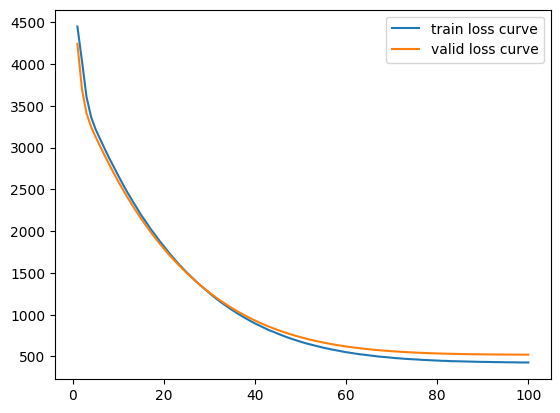

In [14]:
plt.plot(range(1, len(results['train_loss']) + 1), results['train_loss']);
plt.plot(range(1, len(results['valid_loss']) + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])
# plt.ylim(bottom=0, top=50)

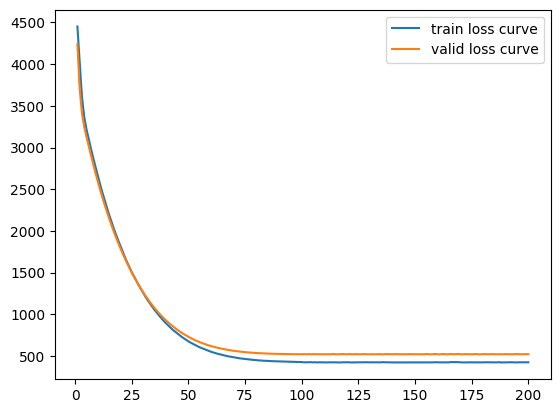

In [20]:
plt.plot(range(1, 201), results['train_loss'] + results2['train_loss']);
plt.plot(range(1, 201), results['valid_loss'] + results2['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])
# plt.ylim(bottom=0, top=50)

In [10]:
# Put model in evaluation mode
model.eval()

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for data, targets in train_dataloader:
        # Send data to target device
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate and accumulate loss
        loss = loss_fn(targets, predictions)

In [11]:
pd.DataFrame({'targets': targets.cpu().squeeze(), 'predictions': predictions.cpu().squeeze()}, index=range(len(targets.cpu())))

,targets,predictions
0,75.757576,62.953152
1,73.076920,62.953152
2,77.142860,62.953152
3,16.129032,62.953152
4,71.875000,62.953152
...,...,...
227,74.285713,62.953152
228,71.875000,62.953152
229,71.875000,62.953152
230,63.636364,62.953152


In [18]:
targets.mean()

tensor(62.7454, device='cuda:0')

In [19]:
predictions.mean()

tensor(62.4944, device='cuda:0')

In [54]:
print(model)

RNN(
  (rnn): LSTM(78, 256, num_layers=5, batch_first=True)
  (fc): Linear(in_features=1280, out_features=1, bias=True)
)


In [60]:
import torch.nn as nn

In [ ]:
fc = nn.Linear(1024, 1)

In [ ]:
fc = nn.Sequential([
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
])

In [ ]:
(N,L,D∗H 
out
​
 )

In [2]:
t = torch.rand(size=(16, 238, 256))
t.shape

torch.Size([16, 238, 256])

In [6]:
t[:, -1, :].shape

torch.Size([16, 256])